___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://miro.medium.com/max/974/1*doaqR0rl1TZtevGrWjcS4g.png" width="500px" height="100px" />


# <font color= #8A0829> Análisis problema práctico.</font>

<Strong> Objetivos </Strong>
- Analizar un problema práctico donde se apliquen las herramientas previamente estudiadas de modelos de series de tiempo.
> Referencias: 
    > - https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_sarimax_stata.html
    > - https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b
    > - https://towardsdatascience.com/autocorrelation-for-time-series-analysis-86e68e631f77
___

In [212]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels as st
import numpy as np

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import statsmodels
print(statsmodels.__version__)

0.15.0.dev202+g23faea30e


%pip install git+https://github.com/statsmodels/statsmodels

In [213]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import MSTL
from sklearn.preprocessing import power_transform


# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()
    
# Análisis de estacionariedad
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


# Función para realizar descomposición estacional
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    # Gráfica de descomposición
    # 3 - tendencia, observación y residuos y las demás en función de la cantidad de periodos de estacionalidad dados
    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    
    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

# Ejemplo de aplicación 1:

Los datos que se van a analizar para la construcción de un modelo se serie de tiempo tiene las siguientes características. Las entradas en la columna de fecha son números enteros que representan el número de días desde 1899-12-30. Los números enteros del período se refieren a intervalos de 30 minutos en un día de 24 horas, por lo que hay 48 para cada día. El dataset es el siguiente:

In [214]:
import pandas as pd

url = 'https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv'

df = pd.read_csv(url)

# Extraer fecha y hora
df['date'] = df.apply(lambda x:
    pd.Timestamp('1899-12-30') + pd.Timedelta(x['Date'], unit='D') + 
                      pd.Timedelta((x['Period'] - 1) * 30, unit='m'),
                      axis=1)

df.head()

,Date,Period,OperationalLessIndustrial,Industrial,date
0,37257,1,3535.867064,1086.132936,2002-01-01 00:00:00
1,37257,2,3383.499028,1088.500972,2002-01-01 00:30:00
2,37257,3,3655.527552,1084.472448,2002-01-01 01:00:00
3,37257,4,3510.446636,1085.553364,2002-01-01 01:30:00
4,37257,5,3294.697156,1081.302844,2002-01-01 02:00:00


Seleccionemos sólo una porción de la serie de tiempo para nuestro análisis:

In [215]:
# Tomar sólo la columna date y OperationalLessIndustrial --> y
timeseries = df[['date', 'OperationalLessIndustrial']]
timeseries.columns = ['date', 'y']

# Tomar sólo los primeros 149 días del 2012
start = pd.to_datetime('2012-01-01')
end = start + pd.Timedelta('149D')
mask = (timeseries['date'] >= start) & (timeseries['date'] <= end)
timeseries = timeseries[mask]

# Hacer un re muestreo de los datos para que queden de forma horaria (sumarlos)
timeseries = timeseries.set_index('date').resample('H').sum()

timeseries.head()

,y
date,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


Ahora importaré las funcionas que hemos desarrollado hasta el momento en clases previas:

## 1. Análisis gráfico

In [11]:
%matplotlib widget

<Axes: xlabel='date'>

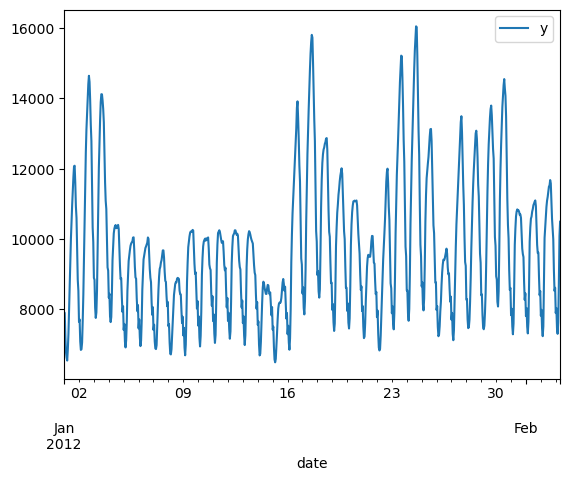

In [216]:
# Graficar la serie de tiempo
timeseries[:800].plot()

Obtener conclusiones...

Análizar distribución de los datos y posibles transformaciones

<Axes: >

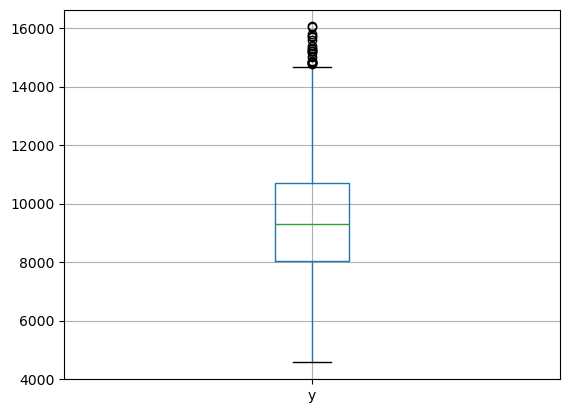

In [128]:
# Distribución de datos originales
timeseries.boxplot()

In [129]:
# Estacionariedad de los datos originales
adf_test(timeseries)

Results of Dickey-Fuller Test:
Test Statistic                -6.037180e+00
p-value                        1.373164e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.546000e+03
Critical Value (1%)           -3.432195e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


# 1. Transformación/escalado de variable de interés

## a). Transformación logarítmica/sqtr

Text(0.5, 1.0, 'datos transformados')

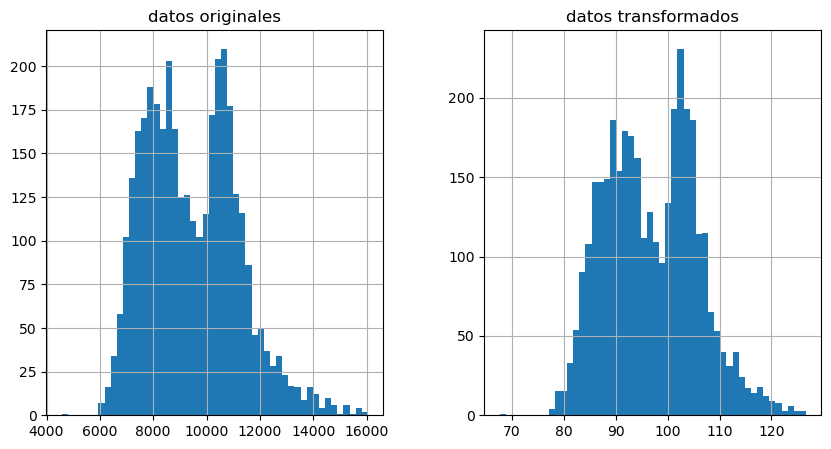

In [154]:
# Obtener histograma con la transformación logarítmica y sqrt
fig, ax = plt.subplots(1, 2, figsize=(10,5))

timeseries.hist(bins=50, ax=ax[0])
ax[0].set_title('datos originales')
np.sqrt(timeseries).hist(bins=50, ax=ax[1])
ax[1].set_title('datos transformados')

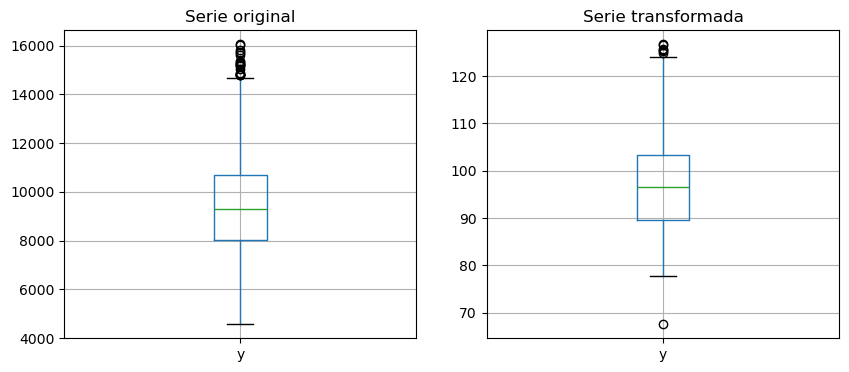

In [155]:
# Calcular el boxplot antes y después de la transformación
fig, ax = plt.subplots(1, 2, figsize=(10,4))
timeseries.boxplot(ax=ax[0])
ax[0].set_title('Serie original')

np.sqrt(timeseries).boxplot(ax=ax[1])
ax[1].set_title('Serie transformada')
plt.show()

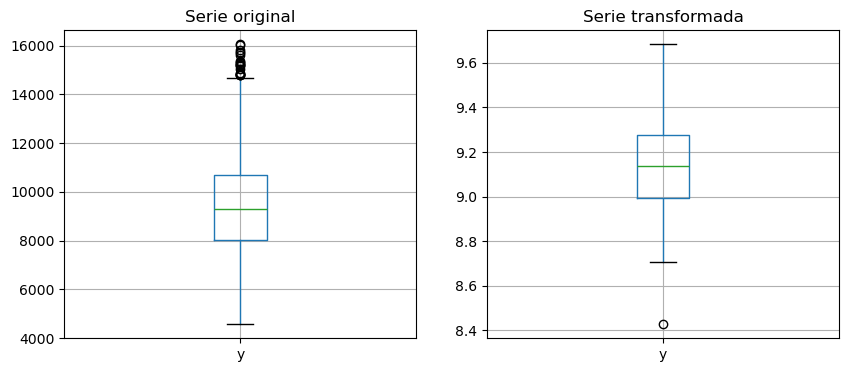

In [156]:
# Calcular el boxplot antes y después de la transformación
fig, ax = plt.subplots(1, 2, figsize=(10,4))
timeseries.boxplot(ax=ax[0])
ax[0].set_title('Serie original')

np.log(timeseries).boxplot(ax=ax[1])
ax[1].set_title('Serie transformada')
plt.show()

## b). Transformación de box-cox, yeo-johnson

<Axes: >

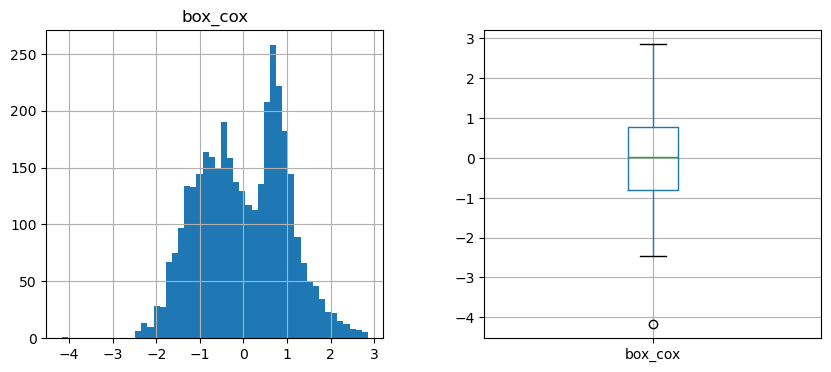

In [157]:
vals_bc = power_transform(timeseries.to_numpy().reshape(-1, 1), method='box-cox')

fig, ax = plt.subplots(1, 2, figsize=(10,4))

transform_bc = pd.DataFrame({'box_cox': vals_bc.squeeze()})
transform_bc.hist(bins=50, ax=ax[0])
transform_bc.boxplot(ax=ax[1])

<Axes: >

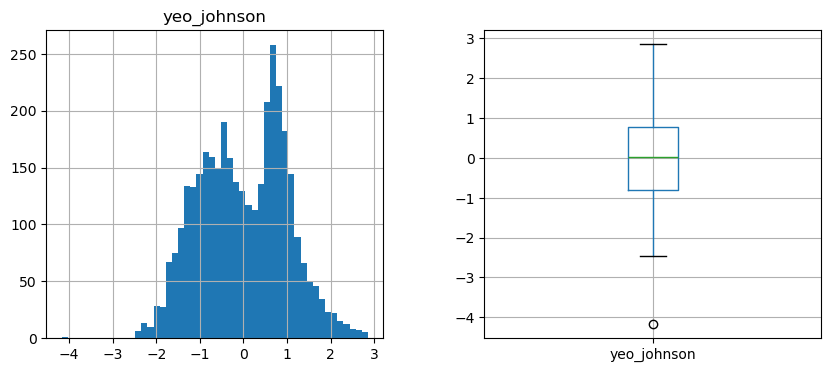

In [158]:
vals_yj = power_transform(timeseries.to_numpy().reshape(-1, 1), method='yeo-johnson')

fig, ax = plt.subplots(1, 2, figsize=(10,4))

transform_yj = pd.DataFrame({'yeo_johnson': vals_yj.squeeze()})
transform_yj.hist(bins=50, ax=ax[0])
transform_yj.boxplot(ax=ax[1])

## c). Escalado usando `MinMaxScaler` y `StandartScaler`

In [159]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

# MinMaxScaler
mm_scaler = MinMaxScaler()
vals_mm = mm_scaler.fit_transform(timeseries)
vals_mm

array([[0.29248867],
       [0.29033783],
       [0.23408118],
       ...,
       [0.47518896],
       [0.45241439],
       [0.        ]])

<Axes: >

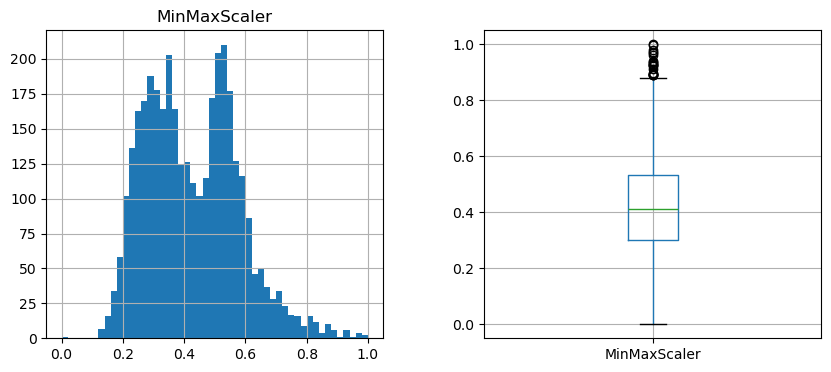

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

pd.DataFrame({'MinMaxScaler': vals_mm.squeeze()}).hist(bins=50, ax=ax[0])
pd.DataFrame({'MinMaxScaler': vals_mm.squeeze()}).boxplot(ax=ax[1])

<Axes: >

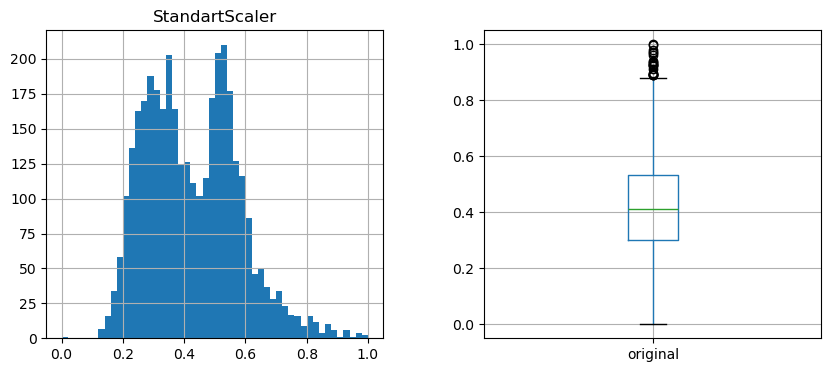

In [161]:
scaler = StandardScaler()
vals_ss = scaler.fit_transform(timeseries.values.reshape(-1, 1))


fig, ax = plt.subplots(1, 2, figsize=(10,4))

pd.DataFrame({'StandartScaler': vals_mm.squeeze()}).hist(bins=50, ax=ax[0])

pd.DataFrame({'original': vals_mm.squeeze()}).boxplot(ax=ax[1])

In [162]:
timeseries['log'] = np.log(timeseries['y'])

timeseries['sqrt'] = np.sqrt(timeseries['y'])

timeseries['box_cox'] = vals_bc

timeseries['jeo_j'] = vals_yj

timeseries['mm_scaler'] = vals_mm

timeseries['std_scaler'] = vals_ss

timeseries.head()

,y,log,sqrt,box_cox,jeo_j,mm_scaler,std_scaler
date,,,,,,,
2012-01-01 00:00:00,7926.529376,8.977971,89.031058,-0.880572,-0.880573,0.292489,-0.884287
2012-01-01 01:00:00,7901.826990,8.974849,88.892221,-0.898247,-0.898248,0.290338,-0.898456
2012-01-01 02:00:00,7255.721350,8.889546,85.180522,-1.385386,-1.385385,0.234081,-1.269049
2012-01-01 03:00:00,6792.503352,8.823575,82.416645,-1.767585,-1.767582,0.193749,-1.534742
2012-01-01 04:00:00,6635.984460,8.800262,81.461552,-1.903797,-1.903793,0.180120,-1.624518


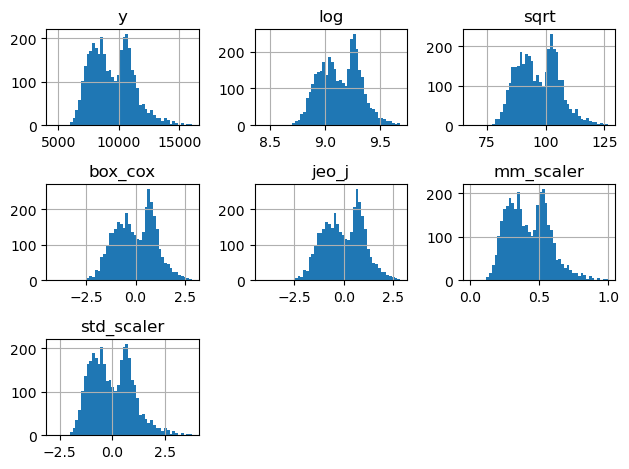

In [163]:
timeseries.hist(bins=50)
plt.tight_layout()

## 2. Análisis de estacionalidad

## 2.1). Análisis de estacionariedad

In [164]:
# Decidir cuál serie de tiempo tomar para el análisis
col_analisis = 'log'
seasonality_data = timeseries[col_analisis]

<Axes: xlabel='date'>

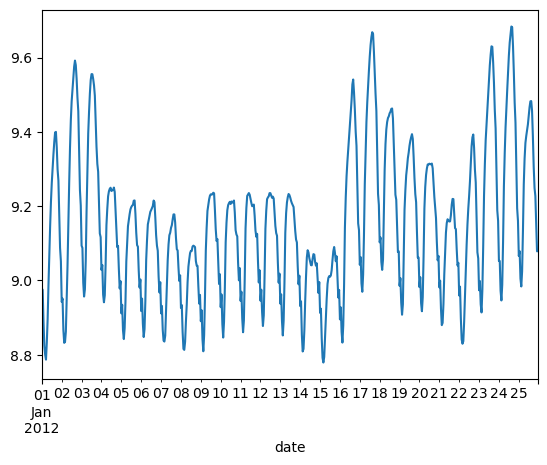

In [87]:
# Gráficar la serie de tiempo


In [88]:
# Análisis de estacionariedad


Results of Dickey-Fuller Test:
Test Statistic                -5.998646e+00
p-value                        1.677874e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.546000e+03
Critical Value (1%)           -3.432195e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


## a). Analizar autocorrelación

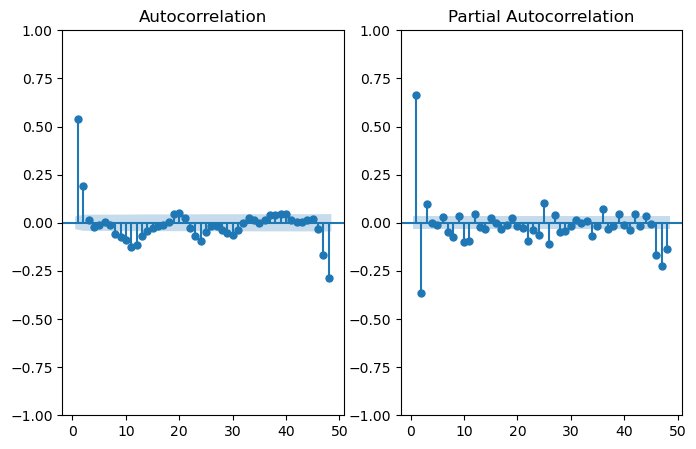

In [165]:
# Graficar ACF y PAC -> datos no estacionales
plot_acf_pacf(, {'lags': 48})

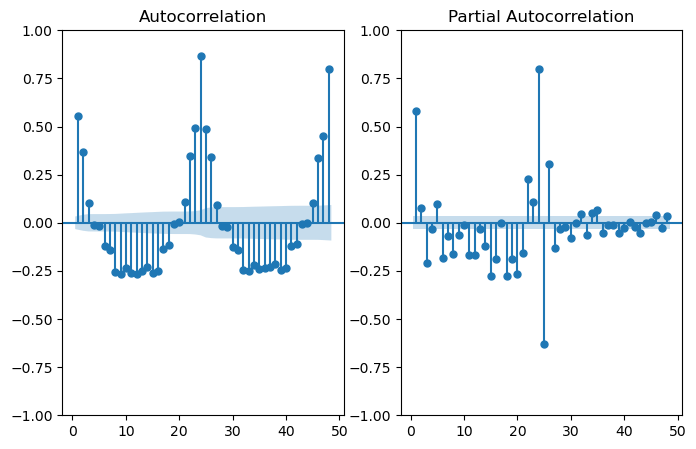

In [95]:
# Graficar ACF y PAC -> datos estacionarios (con estacionalidad)
plot_acf_pacf(, {'lags': 48})

### 2.2). Descomponer la serie de tiempo en las componentes estaciones detectadas.

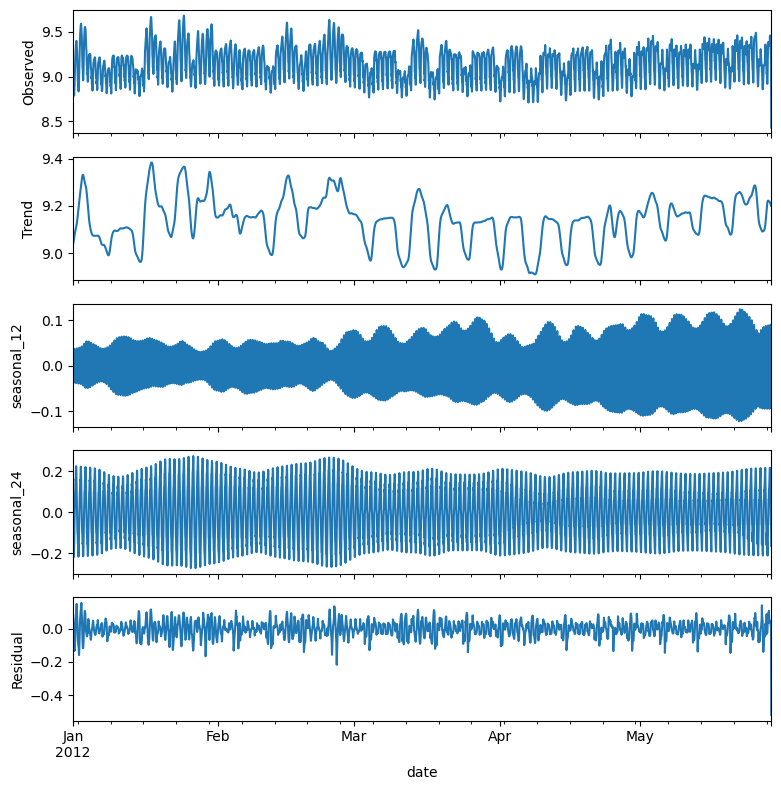

In [166]:
# Función para análisis de estacionalidad
periods_seasonality = (12, 24)

res2 = mstl_descomposition(seasonality_data, periods_seasonality)

In [20]:
%matplotlib inline

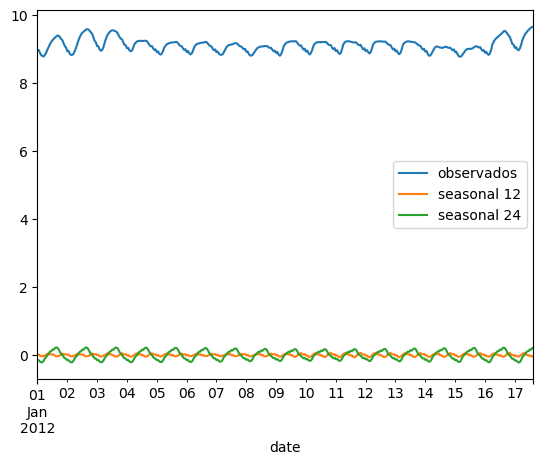

In [98]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed[:400].plot(label='observados')

res2.seasonal['seasonal_12'][:400].plot(ax=ax, label='seasonal 12')
res2.seasonal['seasonal_24'][:400].plot(ax=ax, label='seasonal 24')

plt.legend()
plt.show()

### 2.3). Estacionariedad de la estacionalidad encontrada

In [99]:
# En base a la estacionalidad seleccionada, calcular la estacionariedad de dicha serie temporal
seasonality_24 = res2.seasonal['seasonal_24']

adf_test(seasonality_24)

Results of Dickey-Fuller Test:
Test Statistic                  -37.458364
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    3546.000000
Critical Value (1%)              -3.432195
Critical Value (5%)              -2.862355
Critical Value (10%)             -2.567204
dtype: float64
Stationary


In [100]:
# Estacionariedad de la segunda parte estacional
seasonality_12 = res2.seasonal['seasonal_12']

adf_test(seasonality_12)

Results of Dickey-Fuller Test:
Test Statistic                -1.274858e+01
p-value                        8.632584e-24
#Lags Used                     3.000000e+01
Number of Observations Used    3.546000e+03
Critical Value (1%)           -3.432195e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


In [101]:
# Estacionariedad de los residuos
adf_test(res2.resid)

Results of Dickey-Fuller Test:
Test Statistic                -1.683620e+01
p-value                        1.147623e-29
#Lags Used                     2.600000e+01
Number of Observations Used    3.550000e+03
Critical Value (1%)           -3.432193e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


In [102]:
# Estacionariedad de la tendencia
adf_test(res2.trend)

Results of Dickey-Fuller Test:
Test Statistic                   -5.317690
p-value                           0.000005
#Lags Used                       30.000000
Number of Observations Used    3546.000000
Critical Value (1%)              -3.432195
Critical Value (5%)              -2.862355
Critical Value (10%)             -2.567204
dtype: float64
Stationary


### d). Determinar parámetros $(P,D,Q,S)$ 
$(P, D, Q, S)$ (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

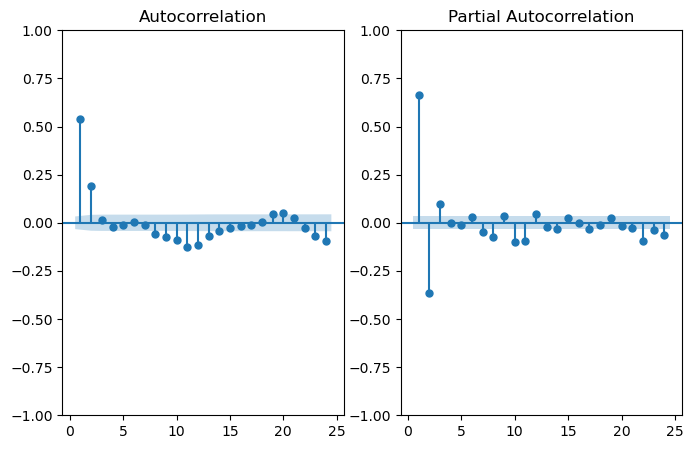

In [167]:
# Graficar ACF y PACF - > Analizar el caso cuando se diferencia la serie estacional seleccionada
plot_acf_pacf(, {'lags': 24})

Concluir...

Posibles valores

    P ->
    D ->
    Q ->

In [ ]:
P = 3
Q = 2
D = 1

## 3. Componente no estacional $(p, d, q)$

In [114]:
# Calcular la estacionariedad de mis datos observados
adf_test(res2.observed.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -5.998646e+00
p-value                        1.677874e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.546000e+03
Critical Value (1%)           -3.432195e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


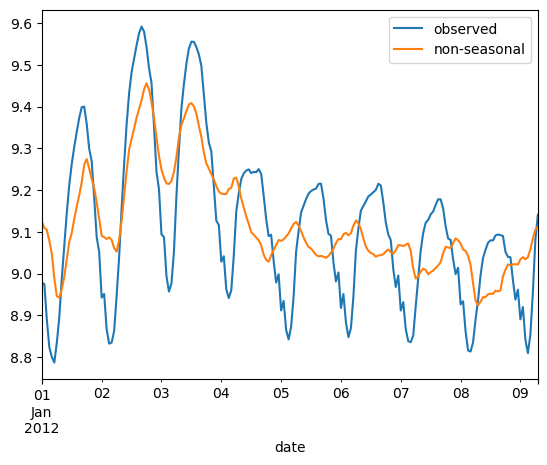

In [115]:
# Calcular la componente no estacional de la serie temporal basado en la S anterior
non_seasonal = 

res2.observed[:200].plot()
non_seasonal[:200].plot()
plt.legend(['observed', 'non-seasonal'])

In [117]:
# Calcular si la serie no estacional es estacionaria o no
adf_test(non_seasonal.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -5.912204e+00
p-value                        2.622761e-07
#Lags Used                     2.700000e+01
Number of Observations Used    3.549000e+03
Critical Value (1%)           -3.432194e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


## a). Analizar autocorrelación

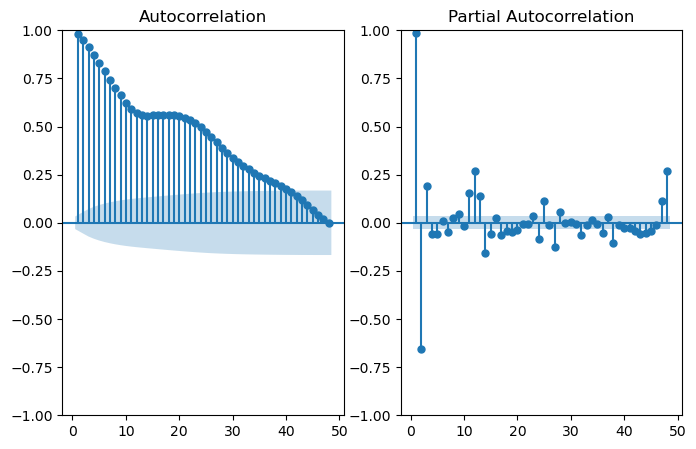

In [121]:
# Graficar ACF y PACF para obtener valores de p y q (analizar el efecto de diferenciar diff())
plot_acf_pacf(non_seasonal.dropna(), {'lags': 48})

Concluir...

Posibles valores

    p ->
    d ->
    q ->

In [ ]:
p = 5
q = 0
d = 0

# Un poco de teoría de los modelos SARIMAX

Analicemos matemáticamente un modelo SARIMAX. Generalmente este modelo se escribe como un modelo ARIMA$(p,d,q) \times (P,D,Q)_s$, donde las letras minúsculas indican la especificación para el componente **no estacional** y las letras **mayúsculas** indican la especificación para el **componente estacional**; $S$ es la periodicidad de las estaciones (por ejemplo, suele ser 4 para datos trimestrales o 12 para datos mensuales). El proceso se puede escribir genéricamente como:
$$
\phi_p (L) \tilde \phi_P (L^s) \Delta^d \Delta_s^D y_t = A(t) + \theta_q (L) \tilde \theta_Q (L^s) \epsilon_t
$$
dónde:
- $\phi_p (L)$ es el polinomio de rezago autorregresivo no estacional
- $\tilde \phi_P (L^s)$ es el polinomio de retraso autorregresivo estacional
- $\Delta^d \Delta_s^D y_t$ es la serie temporal, los tiempos diferenciados y los diferenciados estacionalmente
- $A(t)$ es el polinomio de tendencia (incluida la intersección)
- $\theta_q (L)$ es el polinomio de rezago promedio móvil no estacional
- $\tilde \theta_Q (L^s)$ es el polinomio de retraso de la media móvil estacional

Consideremos como ejemplo el siguiente modelo ARIMA$(2,1,0)\times (1,1,0)_{12}$ con un intercepto. El proceso de datos se puede escribir en el formulario anterior como:
$$
(1 - \phi_1 L - \phi_2 L^2) (1 - \tilde \phi_1 L^{12}) \Delta \Delta_{12} y_t = c + \epsilon_t
$$

Considerando $y_t^* = \Delta \Delta_{12} y_t$ el modelo se puede reescribir de la siguiente forma:
$$
y_t^* = c + \phi_1 y_{t-1}^* + \phi_2 y_{t-2}^* + \tilde \phi_1 y_{t-12}^* - \phi_1 \tilde \phi_1 y_{t-13}^* - \phi_2 \tilde \phi_1 y_{t-14}^* + \epsilon_t.
$$

Si pensamos que nuestro modelo puede tener más de una valor $(p,d,q,P,D,Q)$ entonces una buena idea podría hacer una búsqueda exhaustiva en un espacio definido. Por ejemplo,

In [125]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]
# Parte estacional
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

# Explorar función itertools.product
no_estacional = list(itertools.product(p, d, q))
estacional = list(itertools.product(P, D, Q, [12]))

# Diferentes conmbinaciones
sarimax_params = (list(itertools.product(no_estacional, estacional, t)))

sarimax_params

[((0, 0, 0), (0, 0, 0, 12), 'n'),
 ((0, 0, 0), (0, 0, 0, 12), 'c'),
 ((0, 0, 0), (0, 0, 0, 12), 't'),
 ((0, 0, 0), (0, 0, 0, 12), 'ct'),
 ((0, 0, 0), (0, 0, 1, 12), 'n'),
 ((0, 0, 0), (0, 0, 1, 12), 'c'),
 ((0, 0, 0), (0, 0, 1, 12), 't'),
 ((0, 0, 0), (0, 0, 1, 12), 'ct'),
 ((0, 0, 0), (0, 0, 2, 12), 'n'),
 ((0, 0, 0), (0, 0, 2, 12), 'c'),
 ((0, 0, 0), (0, 0, 2, 12), 't'),
 ((0, 0, 0), (0, 0, 2, 12), 'ct'),
 ((0, 0, 0), (0, 1, 0, 12), 'n'),
 ((0, 0, 0), (0, 1, 0, 12), 'c'),
 ((0, 0, 0), (0, 1, 0, 12), 't'),
 ((0, 0, 0), (0, 1, 0, 12), 'ct'),
 ((0, 0, 0), (0, 1, 1, 12), 'n'),
 ((0, 0, 0), (0, 1, 1, 12), 'c'),
 ((0, 0, 0), (0, 1, 1, 12), 't'),
 ((0, 0, 0), (0, 1, 1, 12), 'ct'),
 ((0, 0, 0), (0, 1, 2, 12), 'n'),
 ((0, 0, 0), (0, 1, 2, 12), 'c'),
 ((0, 0, 0), (0, 1, 2, 12), 't'),
 ((0, 0, 0), (0, 1, 2, 12), 'ct'),
 ((0, 0, 0), (1, 0, 0, 12), 'n'),
 ((0, 0, 0), (1, 0, 0, 12), 'c'),
 ((0, 0, 0), (1, 0, 0, 12), 't'),
 ((0, 0, 0), (1, 0, 0, 12), 'ct'),
 ((0, 0, 0), (1, 0, 1, 12), 'n'),
 ((0, 0

In [126]:
len(sarimax_params)

1296

# 5. Con los datos escalados encontrar el conjunto más adecuado de parámetros

In [98]:
sarimax_params[0]

((0, 0, 0), (0, 0, 0, 12), 'n')

In [170]:
seasonality_data.shape[0]

3577

In [173]:
# Seleccionar sólo un 10% de los datos para hacer optimización paramétrica
train_data = 

In [174]:
# encuentre el 'combo más adecuado' de parámetros no estacionales y estacionales
resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'])

i=0
for non_seasonal, seasonal, trend in sarimax_params[200:210]:
    mod = SARIMAX(
        endog=train_data,
        trend=trend,
        order=non_seasonal,
        seasonal_order=seasonal
    )
    results = mod.fit(disp=False)
    
    resultados.loc[i, 'params'] = str((non_seasonal, seasonal, trend))
    resultados.loc[i,'AIC'] = results.aic
    resultados.loc[i,'BIC'] = results.bic
    resultados.loc[i,'LLF'] = results.llf
    i += 1

# print(f'AIC={results.aic}', f'BIC={results.bic}', f'Log-likelihood={results.llf}', sep='\n')
resultados

,params,AIC,BIC,LLF
0,"((0, 0, 2), (2, 0, 2, 12), 'n')",-1354.964506,-1327.820355,684.482253
1,"((0, 0, 2), (2, 0, 2, 12), 'c')",-957.903003,-926.881117,486.951501
2,"((0, 0, 2), (2, 0, 2, 12), 't')",-1238.930915,-1207.909029,627.465457
3,"((0, 0, 2), (2, 0, 2, 12), 'ct')",-624.444986,-589.545364,321.222493
4,"((0, 0, 2), (2, 1, 0, 12), 'n')",-1418.645317,-1399.427595,714.322659
5,"((0, 0, 2), (2, 1, 0, 12), 'c')",-1417.624338,-1394.563072,714.812169
6,"((0, 0, 2), (2, 1, 0, 12), 't')",-647.86068,-624.799413,329.93034
7,"((0, 0, 2), (2, 1, 0, 12), 'ct')",-1402.119482,-1375.214671,708.059741
8,"((0, 0, 2), (2, 1, 1, 12), 'n')",-1418.752137,-1395.69087,715.376068
9,"((0, 0, 2), (2, 1, 1, 12), 'c')",-1415.434992,-1388.530181,714.717496


In [175]:
resultados.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
8,"((0, 0, 2), (2, 1, 1, 12), 'n')",-1418.752137,-1395.69087,715.376068
4,"((0, 0, 2), (2, 1, 0, 12), 'n')",-1418.645317,-1399.427595,714.322659
5,"((0, 0, 2), (2, 1, 0, 12), 'c')",-1417.624338,-1394.563072,714.812169
9,"((0, 0, 2), (2, 1, 1, 12), 'c')",-1415.434992,-1388.530181,714.717496
7,"((0, 0, 2), (2, 1, 0, 12), 'ct')",-1402.119482,-1375.214671,708.059741
0,"((0, 0, 2), (2, 0, 2, 12), 'n')",-1354.964506,-1327.820355,684.482253
2,"((0, 0, 2), (2, 0, 2, 12), 't')",-1238.930915,-1207.909029,627.465457
1,"((0, 0, 2), (2, 0, 2, 12), 'c')",-957.903003,-926.881117,486.951501
6,"((0, 0, 2), (2, 1, 0, 12), 't')",-647.86068,-624.799413,329.93034
3,"((0, 0, 2), (2, 0, 2, 12), 'ct')",-624.444986,-589.545364,321.222493


In [ ]:
# Luego de encontrar el combo más óptimo ajustar de nuevo el modelo y adicionalmente poner el parámetro 
# de entrada enforce_stationary=True y enforce_invertibility=True (valor por defecto) a False.
# Finalmente llamar el método plot_diagnostics() para analizar la distribución de los residuos

**Parámetros de SARIMAX**
- `dynamic`: También podemos obtener predicciones dinámicas `dynamic=True`. La predicción de un paso adelante utiliza los valores reales de los valores endógenos en cada paso para predecir el siguiente valor dentro de la muestra. Las predicciones dinámicas utilizan la predicción de un paso adelante hasta algún punto del conjunto de datos (especificado por el argumento dinámico); después de eso, los valores endógenos predichos anteriores se usan en lugar de los valores endógenos verdaderos para cada nuevo elemento predicho.
- Si tiene `enforce_stationary=True` y `enforce_invertibility=True` (los valores predeterminados), entonces no es posible obtener un modelo no estacionario/no invertible.
    Si los establece en False, simplemente devolvemos los resultados, ya sea que sean estacionarios/invertibles o no.

In [195]:
n_train = int(0.8 * len(seasonality_data))
n_test = len(seasonality_data) - n_train

train_data_opt = seasonality_data[:n_train]
test_data_opt = seasonality_data[-n_test:]

mod = SARIMAX(
    endog=train_data_opt,
    trend='n',
    order=(0,0,2),
    seasonal_order=(2, 1, 1, 12)
)
results = mod.fit(disp=False)

print(f'AIC={results.aic}', f'BIC={results.bic}', f'Log-likelihood={results.llf}', sep='\n')

AIC=-11208.19141686695
BIC=-11172.463076859962
Log-likelihood=5610.095708433475


In [196]:
test_data_opt

date
2012-04-29 05:00:00    8.784406
2012-04-29 06:00:00    8.833452
2012-04-29 07:00:00    8.865693
2012-04-29 08:00:00    8.932691
2012-04-29 09:00:00    8.975234
                         ...   
2012-05-28 20:00:00    9.357152
2012-05-28 21:00:00    9.290559
2012-05-28 22:00:00    9.212821
2012-05-28 23:00:00    9.186383
2012-05-29 00:00:00    8.426679
Freq: H, Name: log, Length: 716, dtype: float64

In [197]:
train_data_opt

date
2012-01-01 00:00:00    8.977971
2012-01-01 01:00:00    8.974849
2012-01-01 02:00:00    8.889546
2012-01-01 03:00:00    8.823575
2012-01-01 04:00:00    8.800262
                         ...   
2012-04-29 00:00:00    8.951187
2012-04-29 01:00:00    8.946252
2012-04-29 02:00:00    8.858198
2012-04-29 03:00:00    8.801490
2012-04-29 04:00:00    8.776626
Freq: H, Name: log, Length: 2861, dtype: float64

<Axes: xlabel='date'>

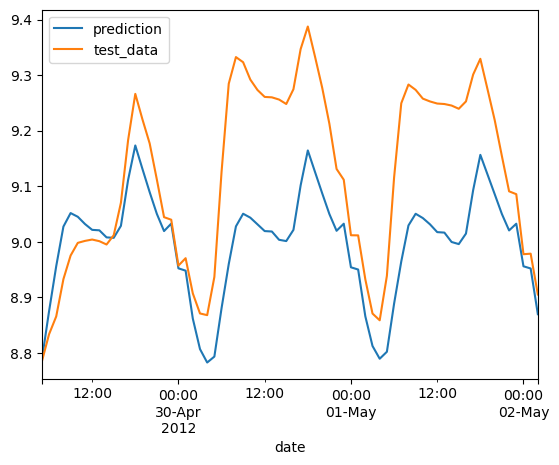

In [199]:
# Explorar el método predict
pred = results.predict(train_data_opt.shape[0], train_data_opt.shape[0] + len(test_data_opt))

ax = pred.to_frame('prediction')[:70].plot()
test_data_opt.to_frame('test_data')[:70].plot(ax=ax)

In [200]:
# Explorar el método get_forecast y su método conf_int() y atributo predicted_mean
forecast = results.get_forecast()

forecast.conf_int(), forecast.predicted_mean

(                     lower log  upper log
 2012-04-29 05:00:00   8.721885   8.853487,
 2012-04-29 05:00:00    8.787686
 Freq: H, dtype: float64)

In [201]:
# Interactuar con las gráficas
%matplotlib widget

In [203]:
results.get_prediction().predicted_mean

date
2012-01-01 00:00:00    0.000000e+00
2012-01-01 01:00:00    2.590078e-07
2012-01-01 02:00:00    3.337546e-07
2012-01-01 03:00:00    3.312676e-07
2012-01-01 04:00:00    3.286533e-07
                           ...     
2012-04-29 00:00:00    8.904644e+00
2012-04-29 01:00:00    8.965392e+00
2012-04-29 02:00:00    8.837006e+00
2012-04-29 03:00:00    8.788793e+00
2012-04-29 04:00:00    8.798283e+00
Freq: H, Name: predicted_mean, Length: 2861, dtype: float64

In [204]:
import datetime

prediction = results.get_prediction()

pred = pd.concat([timeseries, prediction.conf_int(), prediction.predicted_mean], axis=1)
pred

,y,log,sqrt,box_cox,jeo_j,mm_scaler,std_scaler,lower log,upper log,predicted_mean
date,,,,,,,,,,
2012-01-01 00:00:00,7926.529376,8.977971,89.031058,-0.880572,-0.880573,0.292489,-0.884287,-1959.964025,1959.964025,0.000000e+00
2012-01-01 01:00:00,7901.826990,8.974849,88.892221,-0.898247,-0.898248,0.290338,-0.898456,-1959.964025,1959.964026,2.590078e-07
2012-01-01 02:00:00,7255.721350,8.889546,85.180522,-1.385386,-1.385385,0.234081,-1.269049,-1959.964025,1959.964026,3.337546e-07
2012-01-01 03:00:00,6792.503352,8.823575,82.416645,-1.767585,-1.767582,0.193749,-1.534742,-1959.964025,1959.964026,3.312676e-07
2012-01-01 04:00:00,6635.984460,8.800262,81.461552,-1.903797,-1.903793,0.180120,-1.624518,-1959.964025,1959.964026,3.286533e-07
...,...,...,...,...,...,...,...,...,...,...
2012-05-28 20:00:00,11581.352324,9.357152,107.616692,1.190317,1.190318,0.610715,1.212047,NaN,NaN,NaN
2012-05-28 21:00:00,10835.243698,9.290559,104.092477,0.837364,0.837365,0.545751,0.784094,NaN,NaN,NaN
2012-05-28 22:00:00,10024.835748,9.212821,100.124102,0.419631,0.419631,0.475189,0.319260,NaN,NaN,NaN


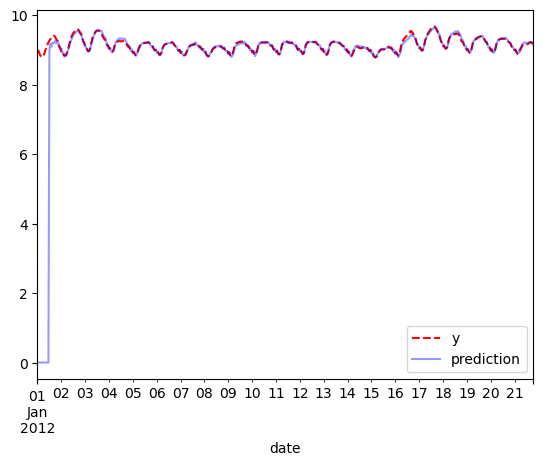

In [210]:
# Explorar el método get_prediction y su método conf_int(), y atributo predicted_mean
import datetime

prediction = results.get_prediction()

pred = pd.concat([timeseries, prediction.conf_int(), prediction.predicted_mean], axis=1)

fig, ax = plt.subplots()
ax = pred[col_analisis][:500].plot(style='r--', label='y')

pred['predicted_mean'][:500].plot(style='b', alpha=.4, ax=ax, label='prediction')

# ax.fill_between(pred.index, pred['lower log'], pred['upper log'], alpha=.2, color='k', label='error') 
plt.legend()
plt.show()
# ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2012, 1, 30)])

<Axes: >

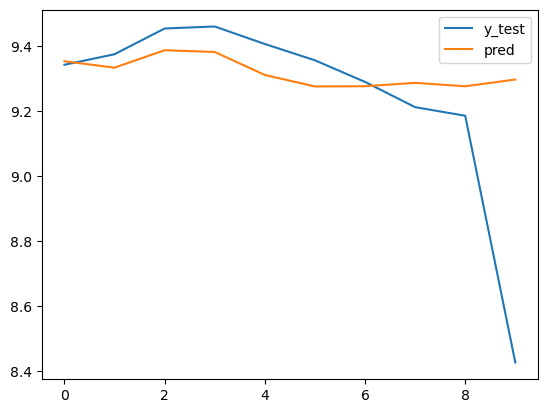

In [211]:
# Particionar la serie de tiempo en train y test y entrenar el modelo iterativamente usando un horizonte
# de predicción. En cada paso de entrenamiento adicionar los valores nuevos del conjunto de test
horizonte = 10
y_train = timeseries['log'][-720:-horizonte].to_numpy()
y_test = timeseries['log'][-horizonte:].to_numpy()

y_pred = []

for i in range(horizonte):
    mod = SARIMAX(
    endog=y_train,
    trend='ct',
    order=(1,0,1),
    seasonal_order=(1, 0, 1, 12)
    )
    results = mod.fit(disp=False)
    
    prediction = results.predict(y_train.shape[0])
    y_train = np.append(y_train, prediction[0])
    y_pred.append(prediction[0])

pd.DataFrame({'y_test': y_test, 'pred':y_pred}).plot()

# Calcular métricas de errores

$$
MAPE = \frac{1}{n}\sum_{t=1}^n \bigg|\frac{\text{Actual - Forecast}}{\text{Actual}}\bigg|
$$
y la desviación absoluta media (MAD)
$$
MAD = \frac{1}{n}\sum_{t=1}^n \big|\text{Actual - Forecast} \big|.
$$


# <font color= Red> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [ ]:
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>